In [1]:
import os
import sys
import scipy as sp
import numpy as np
import pandas as pd
import math
import random
import sys

import matplotlib.pyplot as plt
import pylab as pl
import networkx as nx
import cvxopt as co
import sklearn.cluster as cl
from scipy import sparse
from scipy import ndimage
from numpy import unravel_index
from PIL import Image
from sklearn.metrics.pairwise import euclidean_distances
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn import preprocessing
from sklearn.metrics import (median_absolute_error, mean_squared_error, r2_score, mean_absolute_error, 
                             adjusted_rand_score)

from tcrfr_indep_model import TCrfRIndepModel
from tcrfr_pair_model import TCrfRPairwisePotentialModel
from volume import Vol

from regression_methods import (method_ridge_regression, method_transductive_regression, method_svr, method_krr, 
                                method_tkrr, method_lrr, method_tlrr, method_flexmix, method_tcrfr_v2,
                                method_tcrfr_indep, method_tcrfr, evaluate)

/Users/lual/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1318: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
%matplotlib inline

In [3]:
# Define a color table
colorTable = ((0,0,143,255), (0,0,159,255), (0,0,175,255), (0,0,191,255), (0,0,207,255),
              (0,0,223,255), (0,0,239,255), (0,0,255,255), (0,16,255,255), (0,32,255,255),
              (0,48,255,255), (0,64,255,255), (0,80,255,255), (0,96,255,255), (0,112,255,255),
              (0,128,255,255), (0,143,255,255), (0,159,255,255), (0,175,255,255), (0,191,255,255),
              (0,207,255,255), (0,223,255,255), (0,239,255,255), (0,255,255,255), (16,255,255,255),
              (32,255,239,255), (48,255,223,255), (64,255,207,255), (80,255,191,255), (96,255,175,255),
              (112,255,159,255), (128,255,143,255), (143,255,128,255), (159,255,112,255), (175,255,96,255),
              (191,255,80,255), (207,255,64,255), (223,255,48,255), (239,255,32,255), (255,255,16,255),
              (255,255,0,255), (255,239,0,255), (255,223,0,255), (255,207,0,255), (255,191,0,255),
              (255,175,0,255), (255,159,0,255), (255,143,0,255), (255,128,0,255), (255,112,0,255),
              (255,96,0,255), (255,80,0,255), (255,64,0,255), (255,48,0,255), (255,32,0,255),
              (255,16,0,255), (255,0,0,255), (239,0,0,255), (223,0,0,255), (207,0,0,255),
              (191,0,0,255), (175,0,0,255), (159,0,0,255), (143,0,0,255))
    
# Plot an image
def plot_image(mat, colorTable=colorTable):
    
    # Get image dimensions
    (x,y) = mat.shape
    
    # Get the maximum and minimum values
    minValue = np.amin(mat)
    maxValue = np.amax(mat)

    # Define min and max color indexes
    minIndex = 0
    maxIndex = len(colorTable)-1
    
    # Generate the color index volume
    img_color = np.zeros((x,y), dtype=int)
    img_color = np.round((mat-minValue)/(maxValue-minValue)*(maxIndex-minIndex)+minIndex).astype(int)
        
    # Create and display image
    img = Image.new( 'RGBA', (x,y), "white") # create a new white image
    pixels = img.load() # create the pixel map

    for i in range(img.size[0]):  # for every pixel
        for j in range(img.size[1]):
            pixels[i,j] = (colorTable[img_color[i,j]][0], 
                           colorTable[img_color[i,j]][1], 
                           colorTable[img_color[i,j]][2], 
                           colorTable[img_color[i,j]][3])
    plt.imshow(np.array(img), origin='lower')

In [4]:
# Load inputs, porosity, and facies data
ip = Vol()
si = Vol()
pr = Vol()
pi = Vol()
phi = Vol()
fac = Vol()
ip.read('../Porest-Data/ip_stanford_vi_middle_layer.vol')
si.read('../Porest-Data/si_stanford_vi_middle_layer.vol')
pr.read('../Porest-Data/pr_stanford_vi_middle_layer.vol')
pi.read('../Porest-Data/pi_stanford_vi_middle_layer.vol')
phi.read('../Porest-Data/phi_stanford_vi_middle_layer.vol')
fac.read('../Porest-Data/facies_stanford_vi_middle_layer.vol')

In [5]:
# Simplify facies data (there are only two clusters, anyway)
fac.data[fac.data == 3.] = 0.
fac.data[fac.data == 2.] = 1.

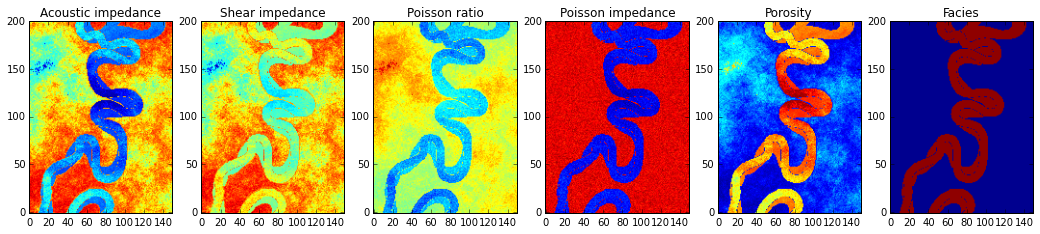

In [6]:
s_n = 31
f = pl.figure(figsize=(18, 14))
ax = f.add_subplot(1, 6, 1)
ip.plotSlice(s_n)
ax.set_title('Acoustic impedance')
ax = f.add_subplot(1, 6, 2)
si.plotSlice(s_n)
ax.set_title('Shear impedance')
ax = f.add_subplot(1, 6, 3)
pr.plotSlice(s_n)
ax.set_title('Poisson ratio')
ax = f.add_subplot(1, 6, 4)
pi.plotSlice(s_n)
ax.set_title('Poisson impedance')
ax = f.add_subplot(1, 6, 5)
phi.plotSlice(s_n)
ax.set_title('Porosity')
ax = f.add_subplot(1, 6, 6)
fac.plotSlice(s_n)
ax.set_title('Facies')

In [7]:
# Run the experiment
sizeX = phi.sizeX
sizeY = phi.sizeY
#sizeZ = phi.sizeZ
sizeZ = 1
train_frac = 0.3
n_train_wells = int(sizeX*sizeY*train_frac) # number of training wells
slice_number = 31 # slice number in the volume
RL = 8 # max radius distance from labeled node to neighbors
RL_x = RL; RL_y = RL; RL_z = 1 # radius distance from labeled node in x,y and z directions
RU = 1 # max radius distance from unlabeled node to neighbors
RU_x = RU; RU_y = RU; RU_z = 1 # radius distance from unlabeled node in x,y and z directions
rel_fac = 0.0 # similarity factor to check if two neighbor samples should be connected by an edge
#sim_fac = 0.995 # similarity factor to check if two neighbor samples should have the same latent state
sim_fac = 0.0 # similarity factor to check if two neighbor samples should have the same latent state
states = 2 # number of facies
REPS = 1 # number of repetitions

# Create the ground truth images
z = slice_number
si_mat = np.zeros((sizeX,sizeY))
pr_mat = np.zeros((sizeX,sizeY))
phi_mat = np.zeros((sizeX,sizeY))
facies_mat = np.zeros((sizeX,sizeY),dtype=int)
for x in range(sizeX):
    for y in range(sizeY):
        si_mat[x,y] = si.data[z,y,x]
        pr_mat[x,y] = pr.data[z,y,x]
        phi_mat[x,y] = phi.data[z,y,x]
        facies_mat[x,y] = fac.data[z,y,x]
        
# Create arrays to store estimated errors and images
errs = np.zeros((REPS,6,6))
flx_facies_mat = np.zeros((REPS, sizeX,sizeY))
flx_phi_mat = np.zeros((REPS, sizeX,sizeY))
svr_phi_mat = np.zeros((REPS, sizeX,sizeY))
rr_phi_mat = np.zeros((REPS, sizeX,sizeY))
tr_phi_mat = np.zeros((REPS, sizeX,sizeY))
tcrfr_facies_mat = np.zeros((REPS, sizeX,sizeY))
tcrfr_phi_mat = np.zeros((REPS, sizeX,sizeY))
shale_coef = np.zeros(REPS)

# Build the graph for the adjacency matrix
print 'creating the graph...',
sys.stdout.flush()
G = nx.Graph()
node_list = []
cz = slice_number
var = np.var(si.data)
for cx in range(sizeX):
    for cy in range(sizeY):
        G.add_node((cx,cy,cz))
        node_list.append((cx,cy,cz))
        u = [cx,cy,cz]
        for i in range(cx,cx+RU_x+1):
            for j in range(cy-RU_y,cy+RU_y+1):
                k = cz
                if (i >= 0 and i < sizeX) and (j >= 0 and j < sizeY):
                    v = [i,j,k]
                    dist = 1.
                    rel = math.exp(-(si.data[cz,cy,cx]-si.data[k,j,i])**2/(2*var))/dist
                    if rel >= rel_fac:
                        d = euclidean_distances(u,v)
                        if d > 0. and d <= RU:
                            G.add_edge((cx,cy,cz),(i,j,k),weight=2)
print 'done!'
sys.stdout.flush()

creating the graph... done!


Iteration 0
creating the train and test sets... done!
adding new edges for the labeled data... done!
building the sparse matrix... done!


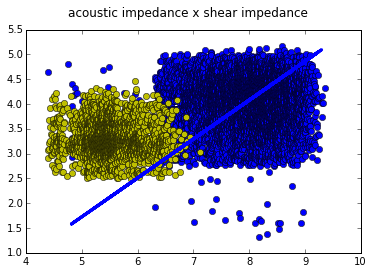

running flexmix... done!
running svr... done!
running rr... done!
running tr... done!
running tcrfr... 210.0

TCRFR Properties:
- Samples       : 30000
- Labeled       : 9000
- Unlabeled     : 21000
- Features      : 2
- CRF Dims      : 8 = 4+4
-------------------------------
- Lambda        : 1e-05
- Gamma         : 30000000.0
- Theta         : 0.8
- Q_regs        : [0.01, 0.5]
-------------------------------
- Edges         : 1410813
- States        : 2
- Trans-types   : 1
- Trans-Sym     : [0]

( 1 ):  0.3232
( 2 ):  0.119633333333
( 3 ):  0.0898
( 4 ):  0.0278666666667
( 5 ):  0.0301
( 6 ):  0.0156666666667
( 7 ):  0.0205
( 8 ):  0.0131333333333
( 9 ):  0.0161
( 10 ):  0.014
Iter=0 regr=9460.76 crf=-375872.34; objective=-67605.86 rel=14792.6181 lats=2
( 1 ):  0.326733333333
( 2 ):  0.0699666666667
( 3 ):  0.0818666666667
( 4 ):  0.0397333333333
( 5 ):  0.0474
( 6 ):  0.0377666666667
( 7 ):  0.0365666666667
( 8 ):  0.0322333333333
( 9 ):  0.0316
( 10 ):  0.0197333333333
Iter=1 regr=

/Users/lual/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: lattice

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [8]:
e_bunch = []
for r in range(REPS):
    print 'Iteration '+ str(r)
    print 'creating the train and test sets...',
    sys.stdout.flush()    
    # Set input features and output
    X = []
    y = []
    facies = []
    vol_inds = []
    cz = slice_number
    for i in range(sizeX): 
        for j in range(sizeY):
            X.append([si.data[cz,j,i]])    
            y.append(phi.data[cz,j,i])
            facies.append(int(fac.data[cz,j,i]))
            vol_inds.append((i,j,cz))
       
    # Obtain the labeled data (from the "wells")
    test = list(np.arange(sizeX*sizeY))
    img_inds = list(np.ndindex((sizeX,sizeY)))
    inds = list(test)
    np.random.shuffle(inds)
    img_size = sizeX*sizeY                        
    
    train = np.array(inds[:n_train_wells])
    test = np.array(inds[n_train_wells:])
    X = np.array(X, copy=True)
    y = np.concatenate(np.array(y, copy=True).reshape((-1,1)))
    facies = np.array(facies)
    print 'done!'
    sys.stdout.flush()
    
    # Add edges for the labeled data
    print 'adding new edges for the labeled data...',
    sys.stdout.flush()
    G.remove_edges_from(e_bunch)
    e_bunch = []
    for l in range(len(train)):
        cx = vol_inds[train[l]][0]
        cy = vol_inds[train[l]][1]
        u = [cx,cy,cz]
        for i in range(cx,cx+RL_x+1):
            for j in range(cy-RL_y,cy+RL_y+1):
                k = cz
                if (i >= 0 and i < sizeX) and (j >= 0 and j < sizeY):
                    v = [i,j,k]
                    dist = 1.
                    rel = math.exp(-(si.data[cz,cy,cx]-si.data[k,j,i])**2/(2*var))/dist
                    if rel >= rel_fac:
                        d = euclidean_distances(u,v)
                        if d > 0. and d <= RL:
                            if not G.has_edge((cx,cy,cz),(i,j,k)):
                                G.add_edge((cx,cy,cz),(i,j,k),weight=2)
                                e_bunch.append(((cx,cy,cz),(i,j,k)))
    print 'done!'
    sys.stdout.flush()
    
    # Create the sparse matrix
    print 'building the sparse matrix...',
    sys.stdout.flush()   
    csr_A = nx.adjacency_matrix(G,nodelist=node_list)
    coo = csr_A.tocoo()
    A = co.spmatrix(1, coo.row.tolist(), coo.col.tolist())
    print 'done!'
    sys.stdout.flush()
        
    # Plot input ip vs si scatter plot
    ip_plot = []
    si_plot = []
    fac_plot = []
    for ind in train:
        cx = vol_inds[ind][0]
        cy = vol_inds[ind][1]
        ip_plot.append(ip.data[cz,cy,cx])
        si_plot.append(si.data[cz,cy,cx])
        fac_plot.append(fac.data[cz,cy,cx])
    ip_plot = np.array(ip_plot)
    si_plot = np.array(si_plot)
    fac_plot = np.array(fac_plot)
    ip0_plot = ip_plot[fac_plot == 0.]
    si0_plot = si_plot[fac_plot == 0.]
    ip1_plot = ip_plot[fac_plot == 1.]   
    si1_plot = si_plot[fac_plot == 1.]
    sinds = np.argsort(ip0_plot)
    plt.plot(ip0_plot[sinds], si0_plot, 'ob', markersize=6.0)
    sinds = np.argsort(ip1_plot)
    plt.plot(ip1_plot[sinds], si1_plot, 'oy', markersize=6.0)
    x0 = ip0_plot.reshape(-1,1)
    y0 = si0_plot.reshape(-1,1)
    lrm = linear_model.LinearRegression()
    lrm.fit(x0,y0)
    pred0 = lrm.predict(x0)
    plt.plot(ip0_plot[sinds], pred0[sinds], 'b', lw=3)
    shale_coef[r] = lrm.coef_
    plt.suptitle('acoustic impedance x shear impedance', fontsize=12)
    pl.show()
 
    # Define some auxiliary arrays
    n_test = len(test)
    pred_flx = np.zeros(n_test)
    pred_svr = np.zeros(n_test)
    pred_rr = np.zeros(n_test)
    pred_tr = np.zeros(n_test)
    pred_tcrfr = np.zeros(n_test)    
    
    # Normalize the data (zero mean and unit variance)
    X = X - np.mean(X[train,:])
    y = y - np.mean(y[train])
    X /= np.max(np.abs(X[train,:]))
    y /= np.max(np.abs(y[train]))
    y *= 10.

    # Set the training and test indexes dependent on the known facies to calculate the lower bounds
    train_0 = []
    train_1 = []
    for ind in train:
        cx = vol_inds[ind][0]
        cy = vol_inds[ind][1]
        if int(fac.data[cz,cy,cx]) == 0:
            train_0.append(ind)
        else:
            train_1.append(ind)
    test_0 = []
    test_1 = []
    for ind in test:
        cx = vol_inds[ind][0]
        cy = vol_inds[ind][1]
        if int(fac.data[cz,cy,cx]) == 0:
            test_0.append(ind)
        else:
            test_1.append(ind)
    train_0 = np.array(train_0)
    train_1 = np.array(train_1)
    test_0 = np.array(test_0)
    test_1 = np.array(test_1)
    
    # Add the intercept to X
    X = np.hstack((X, np.ones((X.shape[0],1))))
    feats = X.shape[1] # number of features
    
    # Run the methods
    print 'running flexmix...',
    sys.stdout.flush()
    (name, pred_flx, lats_flx, lats_flx_all) = method_flexmix(np.array(X, copy=True), np.array(y, copy=True), 
                                                                       train, test, states=states, 
                                                                       params=[400, 0.001])    
    print 'done!'
    sys.stdout.flush()
    
    print 'running svr...',
    sys.stdout.flush()   
    (name, pred_svr, lats_svr) = method_svr(np.array(X, copy=True), np.array(y, copy=True), 
                                                     train, test, states=states, 
                                                     params=[100.,1.,'linear'])
    print 'done!'
    sys.stdout.flush()
    
    print 'running rr...',
    sys.stdout.flush()
    (name, pred_rr, lats_rr) = method_ridge_regression(np.array(X, copy=True), np.array(y, copy=True), 
                                                                train, test, states=states, 
                                                                params=0.01)
    print 'done!'
    sys.stdout.flush()
    
    print 'running tr...',
    sys.stdout.flush()
    (name, pred_tr, lats_tr) = method_transductive_regression(np.array(X, copy=True), np.array(y, copy=True), 
                                                                       train, test, states=states, 
                                                                       params=[0.00001, 1000., 0.1])
    print 'done!'
    sys.stdout.flush()
    
    print 'running tcrfr...',
    sys.stdout.flush()
    (name, pred_tcrfr, lats_tcrfr, lats_tcrfr_all) = method_tcrfr_v2(np.array(X, copy=True), np.array(y, copy=True), 
                                                                  train, test, A, states=states, 
                                                                  params=[0.8, 0.00001, 1000.0, 0.01], plot=False)
    print 'done!'
    sys.stdout.flush() 

    print 'checking the lower bounds...',
    sys.stdout.flush()
    (name, pred_lb_0, lats_lb_0) = method_ridge_regression(np.array(X, copy=True), np.array(y, copy=True), 
                                                                    train_0, test_0, states=1, 
                                                                    params=0.00001)
    
    (name, pred_lb_1, lats_lb_1) = method_ridge_regression(np.array(X, copy=True), np.array(y, copy=True), 
                                                                    train_1, test_1, states=1, 
                                                                    params=0.00001)    
    pred_lb = np.zeros(X.shape[0])
    pred_lb[test_0] = pred_lb_0
    pred_lb[test_1] = pred_lb_1
    lats_lb = np.concatenate((lats_lb_0,lats_lb_1))
    print 'done!'
    sys.stdout.flush()
        
    # Evaluate the performance
    (errs[r,0, :],_) = evaluate(y[test], pred_flx, facies[test], lats_flx)    
    (errs[r,1, :],_) = evaluate(y[test], pred_svr, facies[test], lats_svr)
    (errs[r,2, :],_) = evaluate(y[test], pred_rr, facies[test], lats_rr)
    (errs[r,3, :],_) = evaluate(y[test], pred_tr, facies[test], lats_tr)
    (errs[r,4, :],_) = evaluate(y[test], pred_tcrfr, facies[test], lats_tcrfr)
    (errs[r,5, :],_) = evaluate(y[test], pred_lb[test], facies[test], lats_lb)
   
    # Store image results
    train_img = train[train < img_size]
    for rk in range(len(train_img)):
        ri = img_inds[train_img[rk]][0]
        rj = img_inds[train_img[rk]][1]
#        flx_facies_mat[r,ri,rj] = lats_flx_all[train_img[rk]]
        flx_phi_mat[r,ri,rj] = y[train_img[rk]]        
        svr_phi_mat[r,ri,rj] = y[train_img[rk]]
        rr_phi_mat[r,ri,rj] = y[train_img[rk]]
        tr_phi_mat[r,ri,rj] = y[train_img[rk]]
        tcrfr_facies_mat[r,ri,rj] = lats_tcrfr_all[train_img[rk]]
        tcrfr_phi_mat[r,ri,rj] = y[train_img[rk]]          
    for rk in range(len(test)):
        ri = img_inds[test[rk]][0]
        rj = img_inds[test[rk]][1]
#        flx_facies_mat[r,ri,rj] = lats_flx_all[test[rk]]
        flx_phi_mat[r,ri,rj] = pred_flx[rk]       
        svr_phi_mat[r,ri,rj] = pred_svr[rk]
        rr_phi_mat[r,ri,rj] = pred_rr[rk]
        tr_phi_mat[r,ri,rj] = pred_tr[rk]
        tcrfr_facies_mat[r,ri,rj] = lats_tcrfr_all[test[rk]]
        tcrfr_phi_mat[r,ri,rj] = pred_tcrfr[rk] 
#    tcrfr_facies_mat = (lats_tcrfr_all.reshape(sizeX,sizeY))    

In [9]:
print 'number of training wells: ', n_train_wells

number of training wells:  9000


In [10]:
# Get the averages
err_avg = np.mean(errs,axis=0)
flx_phi_mat_avg = np.mean(flx_phi_mat,axis=0)
svr_phi_mat_avg = np.mean(svr_phi_mat,axis=0)
rr_phi_mat_avg = np.mean(rr_phi_mat,axis=0)
tr_phi_mat_avg = np.mean(tr_phi_mat,axis=0)
tcrfr_phi_mat_avg = np.mean(tcrfr_phi_mat,axis=0)

In [11]:
print ("          MAE        MSE        RMSE       MDAE        R2        ARS")
print ("MOE:     %0.5f    %0.5f    %0.5f    %0.5f    %0.5f    %0.5f" % (err_avg[0,0],err_avg[0,1],err_avg[0,2],err_avg[0,3],err_avg[0,4],err_avg[0,5]))
print ("SVR:     %0.5f    %0.5f    %0.5f    %0.5f    %0.5f    %0.5f" % (err_avg[1,0],err_avg[1,1],err_avg[1,2],err_avg[1,3],err_avg[1,4],err_avg[1,5]))
print ("RR:      %0.5f    %0.5f    %0.5f    %0.5f    %0.5f    %0.5f" % (err_avg[2,0],err_avg[2,1],err_avg[2,2],err_avg[2,3],err_avg[2,4],err_avg[2,5]))
print ("TR:      %0.5f    %0.5f    %0.5f    %0.5f    %0.5f    %0.5f" % (err_avg[3,0],err_avg[3,1],err_avg[3,2],err_avg[3,3],err_avg[3,4],err_avg[3,5]))
print ("TCRFRF:  %0.5f    %0.5f    %0.5f    %0.5f    %0.5f    %0.5f" % (err_avg[4,0],err_avg[4,1],err_avg[4,2],err_avg[4,3],err_avg[4,4],err_avg[4,5]))
print ("L.bound: %0.5f    %0.5f    %0.5f    %0.5f    %0.5f    %0.5f" % (err_avg[5,0],err_avg[5,1],err_avg[5,2],err_avg[5,3],err_avg[5,4],err_avg[5,5]))

          MAE        MSE        RMSE       MDAE        R2        ARS
MOE:     2.41101    8.38361    2.89545    1.64268    0.47553    0.00000
SVR:     1.97303    6.77018    2.60196    1.33249    0.57646    0.00000
RR:      2.06380    6.17579    2.48511    1.93383    0.61365    0.00000
TR:      2.06380    6.17579    2.48511    1.93383    0.61365    0.00000
TCRFRF:  0.89170    2.29183    1.51388    0.27140    0.85663    0.20751
L.bound: 0.15166    0.03522    0.18768    0.13735    0.99780    0.00000


In [12]:
''' 10% with r=6   params=[0.8, 0.00001, 1000.0], plot=False) *    
          MAE        MSE        RMSE       MDAE        R2        ARS
MOE:     0.00000    0.00000    0.00000    0.00000    0.00000    0.00000
SVR:     2.04935    6.59984    2.56901    1.61473    0.60237    0.00000
RR:      2.11690    6.42408    2.53458    2.03951    0.61296    0.00000
TR:      2.11689    6.42409    2.53458    2.03968    0.61296    0.00000
TCRFRF:  0.73722    1.91187    1.38270    0.22017    0.88481    0.34323
L.bound: 0.15513    0.03676    0.19172    0.13984    0.99779    0.00000
'''

' 10% with r=6   params=[0.8, 0.00001, 1000.0], plot=False) *    \n          MAE        MSE        RMSE       MDAE        R2        ARS\nMOE:     0.00000    0.00000    0.00000    0.00000    0.00000    0.00000\nSVR:     2.04935    6.59984    2.56901    1.61473    0.60237    0.00000\nRR:      2.11690    6.42408    2.53458    2.03951    0.61296    0.00000\nTR:      2.11689    6.42409    2.53458    2.03968    0.61296    0.00000\nTCRFRF:  0.73722    1.91187    1.38270    0.22017    0.88481    0.34323\nL.bound: 0.15513    0.03676    0.19172    0.13984    0.99779    0.00000\n'

In [13]:
'''' 10% lambda = 0.8  diag = 0.03, R = 10
          MAE        MSE        RMSE       MDAE        R2        ARS
MOE:     0.00000    0.00000    0.00000    0.00000    0.00000    0.00000
SVR:     1.84118    5.92839    2.43211    1.41819    0.75458    0.00000
RR:      1.90623    5.71714    2.38895    1.63590    0.76312    0.00000
TR:      1.90620    5.71713    2.38894    1.63597    0.76312    0.00000
TCRFRF:  0.83209    2.96011    1.66600    0.26357    0.87384    0.37968
L.bound: 0.18002    0.04623    0.21482    0.16789    0.99808    0.00000
'''

"' 10% lambda = 0.8  diag = 0.03, R = 10\n          MAE        MSE        RMSE       MDAE        R2        ARS\nMOE:     0.00000    0.00000    0.00000    0.00000    0.00000    0.00000\nSVR:     1.84118    5.92839    2.43211    1.41819    0.75458    0.00000\nRR:      1.90623    5.71714    2.38895    1.63590    0.76312    0.00000\nTR:      1.90620    5.71713    2.38894    1.63597    0.76312    0.00000\nTCRFRF:  0.83209    2.96011    1.66600    0.26357    0.87384    0.37968\nL.bound: 0.18002    0.04623    0.21482    0.16789    0.99808    0.00000\n"

In [14]:
''' tcrfr_v2 with 2% and R=15
          MAE        MSE        RMSE       MDAE        R2        ARS
MOE:     2.44860    8.68050    2.94599    1.66866    0.47658    0.00000
SVR:     2.06737    7.25497    2.68952    1.58443    0.56161    0.00000
RR:      2.10737    6.45220    2.53978    1.98613    0.61103    0.00000
TR:      2.10737    6.45220    2.53978    1.98631    0.61103    0.00000
TCRFRF:  0.53666    2.63302    1.61710    0.14739    0.84118    0.75702
L.bound: 0.15600    0.03745    0.19350    0.14005    0.99774    0.00000
'''

' tcrfr_v2 with 2% and R=15\n          MAE        MSE        RMSE       MDAE        R2        ARS\nMOE:     2.44860    8.68050    2.94599    1.66866    0.47658    0.00000\nSVR:     2.06737    7.25497    2.68952    1.58443    0.56161    0.00000\nRR:      2.10737    6.45220    2.53978    1.98613    0.61103    0.00000\nTR:      2.10737    6.45220    2.53978    1.98631    0.61103    0.00000\nTCRFRF:  0.53666    2.63302    1.61710    0.14739    0.84118    0.75702\nL.bound: 0.15600    0.03745    0.19350    0.14005    0.99774    0.00000\n'

In [15]:
''' tcrfr nips Results with 50% of labeled data
          MAE        MSE        RMSE       MDAE        R2        ARS
MOE:     2.38137    8.26571    2.87363    1.63267    0.48093    0.00000
SVR:     1.97212    6.81124    2.60975    1.31041    0.57227    0.00000
RR:      2.06202    6.15930    2.48178    1.92515    0.61319    0.00000
TR:      2.06202    6.15930    2.48178    1.92516    0.61319    0.00000
TCRFRH:  0.19201    0.29627    0.54383    0.13750    0.98139    0.97089
L.bound: 0.15132    0.03510    0.18734    0.13682    0.99780    0.00000
'''

' tcrfr nips Results with 50% of labeled data\n          MAE        MSE        RMSE       MDAE        R2        ARS\nMOE:     2.38137    8.26571    2.87363    1.63267    0.48093    0.00000\nSVR:     1.97212    6.81124    2.60975    1.31041    0.57227    0.00000\nRR:      2.06202    6.15930    2.48178    1.92515    0.61319    0.00000\nTR:      2.06202    6.15930    2.48178    1.92516    0.61319    0.00000\nTCRFRH:  0.19201    0.29627    0.54383    0.13750    0.98139    0.97089\nL.bound: 0.15132    0.03510    0.18734    0.13682    0.99780    0.00000\n'

In [16]:
''' tcrfr nips Results with 2% of labeled data
          MAE        MSE        RMSE       MDAE        R2        ARS
MOE:     2.43003    8.64959    2.94075    1.63019    0.47297    0.00000
SVR:     1.99967    7.22614    2.68585    1.29739    0.55948    0.00000
RR:      2.08934    6.35421    2.52036    1.93182    0.61296    0.00000
TR:      2.08934    6.35416    2.52035    1.93195    0.61296    0.00000
TCRFRH:  0.28907    0.93554    0.96476    0.14133    0.94288    0.90908
L.bound: 0.15446    0.03682    0.19186    0.13900    0.99776    0.00000
'''

' tcrfr nips Results with 2% of labeled data\n          MAE        MSE        RMSE       MDAE        R2        ARS\nMOE:     2.43003    8.64959    2.94075    1.63019    0.47297    0.00000\nSVR:     1.99967    7.22614    2.68585    1.29739    0.55948    0.00000\nRR:      2.08934    6.35421    2.52036    1.93182    0.61296    0.00000\nTR:      2.08934    6.35416    2.52035    1.93195    0.61296    0.00000\nTCRFRH:  0.28907    0.93554    0.96476    0.14133    0.94288    0.90908\nL.bound: 0.15446    0.03682    0.19186    0.13900    0.99776    0.00000\n'

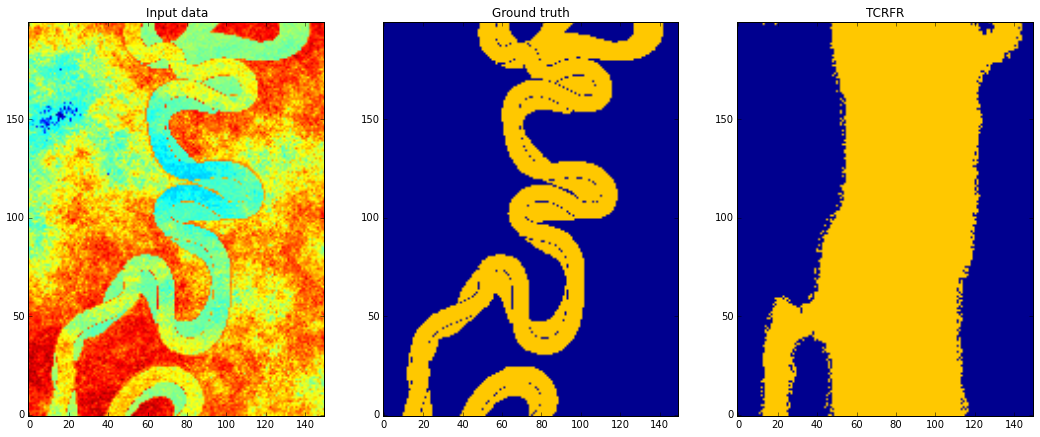

In [17]:
# Plot the facies image results
r = 0
f = pl.figure(figsize=(18, 14))
ax = f.add_subplot(1, 3, 1)
plot_image(si_mat)
ax.set_title('Input data')
ax = f.add_subplot(1, 3, 2)
color_table = ((0,0,143,255), (255,200,0,255))
plot_image(facies_mat, colorTable=color_table)
ax.set_title('Ground truth')
ax = f.add_subplot(1, 3, 3)
#color_table = ((255,200,0,255), (0,0,143,255))
plot_image(tcrfr_facies_mat[r], colorTable=color_table)
ax.set_title('TCRFR')
pl.show()

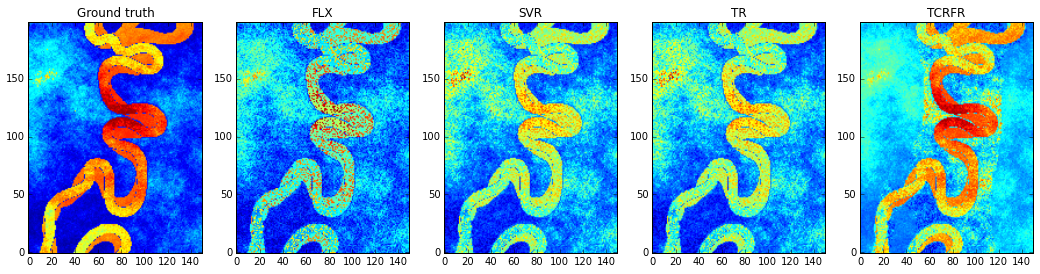

In [18]:
# Plot the porosity image results
f = pl.figure(figsize=(18, 14))
ax = f.add_subplot(1, 5, 1)
plot_image(phi_mat)
ax.set_title('Ground truth')
ax = f.add_subplot(1, 5, 2)
plot_image(flx_phi_mat_avg)
ax.set_title('FLX')
ax = f.add_subplot(1, 5, 3)
plot_image(tr_phi_mat_avg)
ax.set_title('SVR')
ax = f.add_subplot(1, 5, 4)
plot_image(tr_phi_mat_avg)
ax.set_title('TR')
ax = f.add_subplot(1, 5, 5)
plot_image(tcrfr_phi_mat_avg)
ax.set_title('TCRFR')
pl.show()

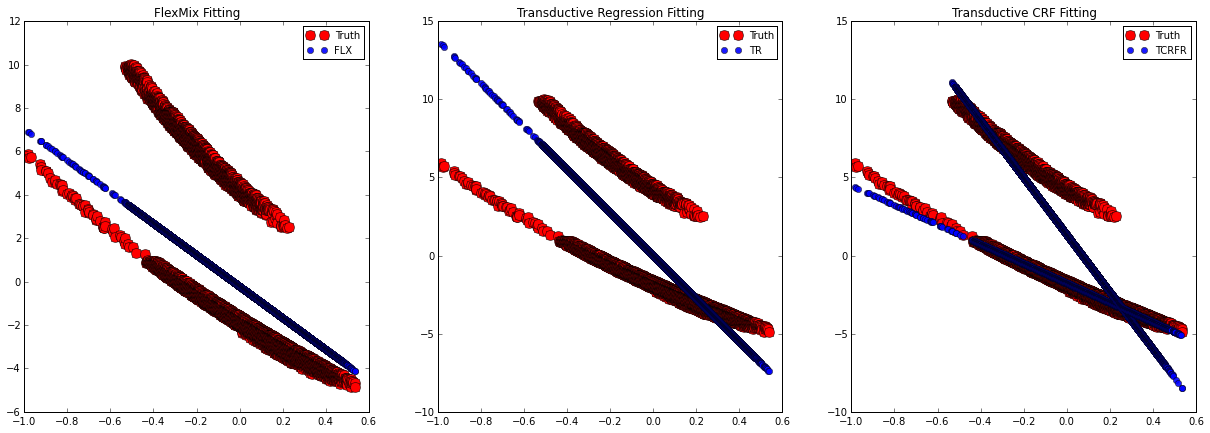

In [19]:
# Plot the fitting curves for the last iteration
sinds = np.argsort(X[test,0])
f = pl.figure(figsize=(21, 7))
ax = f.add_subplot(1, 3, 1)
plt.plot(X[test[sinds],0], y[test[sinds]], 'or', alpha=1.0, markersize=10.0)
plt.plot(X[test[sinds],0], pred_flx[sinds], 'ob', alpha=0.9, markersize=6.0)
plt.legend(['Truth', 'FLX'], loc=1, fontsize=10)
ax.set_title('FlexMix Fitting')
ax = f.add_subplot(1, 3, 2)
plt.plot(X[test[sinds],0], y[test[sinds]], 'or', alpha=1.0, markersize=10.0)
plt.plot(X[test[sinds],0], pred_tr[sinds], 'ob', alpha=0.9, markersize=6.0)
plt.legend(['Truth', 'TR'], loc=1, fontsize=10)
ax.set_title('Transductive Regression Fitting')
ax = f.add_subplot(1, 3, 3)
plt.plot(X[test[sinds],0], y[test[sinds]], 'or', alpha=1.0, markersize=10.0)
plt.plot(X[test[sinds],0], pred_tcrfr[sinds], 'ob', alpha=0.9, markersize=6.0)
plt.legend(['Truth', 'TCRFR'], loc=1, fontsize=10)
ax.set_title('Transductive CRF Fitting')
pl.show()